In [1]:
import tensorflow as tf
import numpy as np
import scipy
from scipy import misc
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import librosa
from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D)
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import load_img,img_to_array
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
from keras.initializers import glorot_uniform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pydub import AudioSegment
import shutil
from keras.preprocessing.image import ImageDataGenerator
import random

In [5]:
os.makedirs('./content/spectrograms3sec')
os.makedirs('./content/spectrograms3sec/train')
os.makedirs('./content/spectrograms3sec/test')

genres = 'blues classical country disco pop hiphop metal reggae rock'
genres = genres.split()
for g in genres:
  path_audio = os.path.join('./content/audio3sec',f'{g}')
  os.makedirs(path_audio)
  path_train = os.path.join('./content/spectrograms3sec/train',f'{g}')
  path_test = os.path.join('./content/spectrograms3sec/test',f'{g}')
  os.makedirs(path_train)
  os.makedirs(path_test)

In [3]:
i = 0
for g in genres:
  j=0
  print(f"{g}")
  for filename in os.listdir(os.path.join('./Data/genres_original',f"{g}")):
    song = os.path.join(f'./Data/genres_original/{g}',f'{filename}')
    j = j+1
    for w in range(0,10):
      i = i+1
      #print(i)
      t1 = 3*(w)*1000
      t2 = 3*(w+1)*1000
      newAudio = AudioSegment.from_wav(song)
      new = newAudio[t1:t2]
      new.export(f'./content/audio3sec/{g}/{g+str(j)+str(w)}.wav', format="wav")

blues
classical
country
disco
pop
hiphop
metal
reggae
rock


blues
0
classical
1
country
2
disco
3
pop
4
hiphop
5
metal
6
reggae
7
rock
8


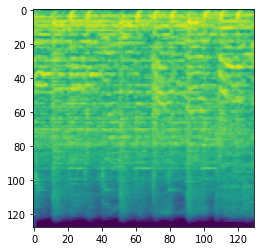

In [14]:
i = 0
genres = 'blues classical country disco pop hiphop metal reggae rock'
genres = genres.split()
for g in genres:
  j = 0
  print(g)
  for filename in os.listdir(os.path.join('./content/audio3sec',f"{g}")):
    song = os.path.join(f'./content/audio3sec/{g}',f'{filename}')
    j = j+1
    y,sr = librosa.load(song,duration=3)
    #print(sr)
    mels = librosa.feature.melspectrogram(y=y,sr=sr)
    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
    plt.savefig(f'./content/spectrograms3sec/train/{g}/{g+str(j)}.png')
    if j>300:
        break

In [15]:
directory = "./content/spectrograms3sec/train/"
for g in genres:
  filenames = os.listdir(os.path.join(directory,f"{g}"))
  random.shuffle(filenames)
  test_files = filenames[0:40]
  for f in test_files:
    shutil.move(directory + f"{g}"+ "/" + f,"./content/spectrograms3sec/test/" + f"{g}")

In [2]:
train_dir = "./content/spectrograms3sec/train/"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(288,432),color_mode="rgba",class_mode='categorical',batch_size=64)

validation_dir = "./content/spectrograms3sec/test/"
vali_datagen = ImageDataGenerator(rescale=1./255)
vali_generator = vali_datagen.flow_from_directory(validation_dir,target_size=(288,432),color_mode='rgba',class_mode='categorical',batch_size=64)

Found 2171 images belonging to 9 classes.
Found 540 images belonging to 9 classes.


In [3]:
def GenreModel(input_shape = (288,432,4),classes=9):
  
  X_input = Input(input_shape)

  X = Conv2D(8,kernel_size=(3,3),strides=(1,1))(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(16,kernel_size=(3,3),strides = (1,1))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(32,kernel_size=(3,3),strides = (1,1))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64,kernel_size=(3,3),strides=(1,1))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Flatten()(X)
  
  X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)

  model = Model(inputs=X_input,outputs=X,name='GenreModel')
    
  return model

In [4]:
import keras.backend as K
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = GenreModel(input_shape=(288,432,4),classes=9)
opt = Adam(learning_rate=0.0005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy',get_f1]) 

history = model.fit_generator(train_generator,epochs=25,validation_data=vali_generator)

<ipython-input-4-3b881a0b6a27>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,epochs=25,validation_data=vali_generator)


Epoch 1/25
34/34 [==============================] - 105s 3s/step - loss: 4.5010 - accuracy: 0.1727 - get_f1: 0.1197 - val_loss: 2.1679 - val_accuracy: 0.1130 - val_get_f1: 0.0000e+00
Epoch 2/25
34/34 [==============================] - 106s 3s/step - loss: 1.6821 - accuracy: 0.3938 - get_f1: 0.3028 - val_loss: 2.3361 - val_accuracy: 0.1463 - val_get_f1: 0.0000e+00
Epoch 3/25
34/34 [==============================] - 106s 3s/step - loss: 1.3022 - accuracy: 0.5136 - get_f1: 0.4560 - val_loss: 2.7165 - val_accuracy: 0.1111 - val_get_f1: 0.0000e+00
Epoch 4/25
34/34 [==============================] - 110s 3s/step - loss: 1.0650 - accuracy: 0.6177 - get_f1: 0.5842 - val_loss: 3.1379 - val_accuracy: 0.1111 - val_get_f1: 0.1316
Epoch 5/25
34/34 [==============================] - 122s 4s/step - loss: 0.9057 - accuracy: 0.6757 - get_f1: 0.6695 - val_loss: 4.0991 - val_accuracy: 0.1111 - val_get_f1: 0.1064
Epoch 6/25
34/34 [==============================] - 127s 4s/step - loss: 0.7947 - accuracy: 0

In [16]:
for g in genres:
  for filename in os.listdir(os.path.join('./content/spectrograms3sec/test',f"{g}")):
    if os.path.isdir(filename):
        # skip directories
        continue
    song = os.path.join(f'./content/spectrograms3sec/test/{g}',f'{filename}')
    img = image.load_img(song, target_size=(288, 432), color_mode="rgba")
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = preprocess_input(img_batch)

    prediction = model.predict(img_preprocessed)
    print(prediction)

    #print(decode_predictions(prediction, top=3)[0])

    

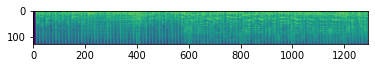

In [19]:
for filename in os.listdir('./tests/songs/'):
    song = os.path.join(f'./tests/songs/',f'{filename}')
    y,sr = librosa.load(song,duration=30)
    #print(sr)
    mels = librosa.feature.melspectrogram(y=y,sr=sr)
    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
    plt.savefig(f'./tests/spectrograms/{filename}.png')

In [7]:
for filename in os.listdir('./tests/spectrograms/'):
    spec = os.path.join(f'./tests/spectrograms/',f'{filename}')
    img = image.load_img(spec, target_size=(288, 432), color_mode="rgba")
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = preprocess_input(img_batch)
    prediction = model.predict(img_batch)
    print(prediction)


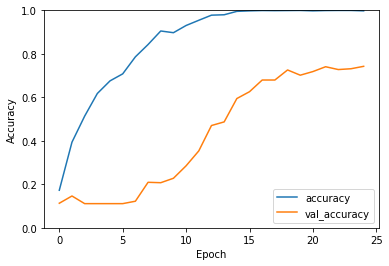

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')


In [11]:
for filename in os.listdir('./tests/songs/'):
    song = os.path.join(f'./tests/songs/',f'{filename}')
    if os.path.isdir(song):
        # skip directories
        continue
    for w in range(0,10):
      t1 = 3*(w)*1000
      t2 = 3*(w+1)*1000
      newAudio = AudioSegment.from_wav(song)
      new = newAudio[t1:t2]
      new.export(f'./tests/songs/3secs/{filename+str(w)}.wav', format="wav")

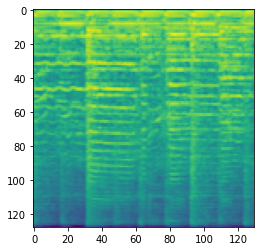

In [13]:
for filename in os.listdir('./tests/songs/3secs/'):
    song = os.path.join(f'./tests/songs/3secs/',f'{filename}')
    y,sr = librosa.load(song,duration=30)
    #print(sr)
    mels = librosa.feature.melspectrogram(y=y,sr=sr)
    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
    plt.savefig(f'./tests/spectrograms/3secs/{filename}.png')

In [17]:
for filename in os.listdir('./tests/spectrograms/3secs/'):
    spec = os.path.join(f'./tests/spectrograms/3secs',f'{filename}')
    img = image.load_img(spec, target_size=(288, 432), color_mode="rgba")
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = preprocess_input(img_batch)
    prediction = model.predict(img_batch)
    print(filename)
    print(prediction)
